# Q-Learning with Function Approximation: Linear Function Approximation and Deep Q-Learning

# Part 1: Linear Function Approximation

## Example: Backgammon Game

In this notebook, we will play the Backgammon game using Q-learning with linear function approximation.

### Problem Desciption

The backgammon game is a 2-player game that involves both the movement of the checkers (Backgammon playing pieces) and also the roll of the dice. The goal of each player is to move all of his checkers off the board [1].
The rules of the Backgammon game can be found in [2].
&nbsp;
&nbsp;

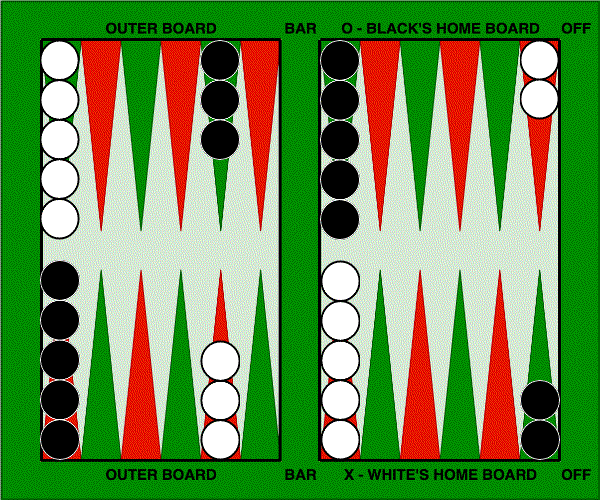

The above figure showing the setup of the game is from [1].
&nbsp;
&nbsp;

### Formulation

- *State* $s$:
    
    The state $s$ consists of 198 observations and the dice rolled.

    The dice rolled is represented by a tuple with two numbers. Postive numbers represents BLACK player and negative numbers represents WHITE player. For example, (1,3) for the BLACK player or (-1, -3) for the WHITE player.

    The range and the encoding of the 198 observations can be found in [1], which are also shown as follows.

| Num       | Observation                                                         | Min  | Max  |
| --------- | -----------------------------------------------------------------   | ---- | ---- |
| 0         | WHITE - 1st point, 1st component                                    | 0.0  | 1.0  |
| 1         | WHITE - 1st point, 2nd component                                    | 0.0  | 1.0  |
| 2         | WHITE - 1st point, 3rd component                                    | 0.0  | 1.0  |
| 3         | WHITE - 1st point, 4th component                                    | 0.0  | 6.0  |
| 4         | WHITE - 2nd point, 1st component                                    | 0.0  | 1.0  |
| 5         | WHITE - 2nd point, 2nd component                                    | 0.0  | 1.0  |
| 6         | WHITE - 2nd point, 3rd component                                    | 0.0  | 1.0  |
| 7         | WHITE - 2nd point, 4th component                                    | 0.0  | 6.0  |
| ...       |                                                                     |      |      |
| 92        | WHITE - 24th point, 1st component                                   | 0.0  | 1.0  |
| 93        | WHITE - 24th point, 2nd component                                   | 0.0  | 1.0  |
| 94        | WHITE - 24th point, 3rd component                                   | 0.0  | 1.0  |
| 95        | WHITE - 24th point, 4th component                                   | 0.0  | 6.0  |
| 96        | WHITE - BAR checkers                                                | 0.0  | 7.5  |
| 97        | WHITE - OFF bar checkers                                            | 0.0  | 1.0  |
| 98        | BLACK - 1st point, 1st component                                    | 0.0  | 1.0  |
| 99        | BLACK - 1st point, 2nd component                                    | 0.0  | 1.0  |
| 100       | BLACK - 1st point, 3rd component                                    | 0.0  | 1.0  |
| 101       | BLACK - 1st point, 4th component                                    | 0.0  | 6.0  |
| ...       |                                                                     |      |      |
| 190       | BLACK - 24th point, 1st component                                   | 0.0  | 1.0  |
| 191       | BLACK - 24th point, 2nd component                                   | 0.0  | 1.0  |
| 192       | BLACK - 24th point, 3rd component                                   | 0.0  | 1.0  |
| 193       | BLACK - 24th point, 4th component                                   | 0.0  | 6.0  |
| 194       | BLACK - BAR checkers                                                | 0.0  | 7.5  |
| 195       | BLACK - OFF bar checkers                                            | 0.0  | 1.0  |
| 196 - 197 | Current player                                                      | 0.0  | 1.0  |

&emsp; &emsp; Encoding of a single point (it indicates the number of checkers in that point):

| Checkers | Encoding                                |           
| -------- | --------------------------------------- |
| 0        | [0.0, 0.0, 0.0, 0.0]                    |
| 1        | [1.0, 0.0, 0.0, 0.0]                    |
| 2        | [1.0, 1.0, 0.0, 0.0]                    |
| >= 3     | [1.0, 1.0, 1.0, (checkers - 3.0) / 2.0] |

&emsp; &emsp; Encoding of BAR checkers:

| Checkers | Encoding             |           
| -------- | -------------------- |
| 0 - 15   | [bar_checkers / 2.0] |

&emsp; &emsp; Encoding of OFF bar checkers:

| Checkers | Encoding              |           
| -------- | --------------------- |
| 0 - 15   | [off_checkers / 15.0] |

&emsp; &emsp; Encoding of the current player:

| Player  | Encoding   |           
| ------- | ---------- |
| WHITE   | [1.0, 0.0] |
| BLACK   | [0.0, 1.0] |


- *Action $a$*:
    
    The valid actions that an agent can execute depend on the current state. So, the shape of the action space depends on the currrent state.

    Each action is a tuple of tuples, in the form ((source, target), (source, target)).
    Each tuple represents a move in the form (source, target).

    $a$=None means passing the current turn. Note that when there is no valid action, the player has to pass their turn. Otherwise, the player cannot pass.

    Examples can be found in [1].
    

- *Reward*:
    
    +1 if player WHITE wins, and 0 if player BLACK wins.

    The reward is zero for all the intermediate steps.
    

- *Objective*: Maximize the expected total discounted reward. This means that we are playing WHITE.
    
    We set the discount factor to be 0.99.


The implementation code of this Backgammon game is from [1] with some modifications.

## Reference
[1] https://github.com/dellalibera/gym-backgammon

[2] https://bkgm.com/rules.html


We set one episode to be one game but we limit the episode length to be less than or equal to 10000.


In [ ]:
# Upload the file "gym-backgammon.zip" and then unzip it
try:
    from google.colab import files
    from zipfile import ZipFile
    uploaded = files.upload()
    with ZipFile("gym-backgammon.zip", 'r') as zip_file:
        zip_file.extractall()
except Exception as e:
    pass

In [ ]:
# Import packages. Run this cell.
import time
from itertools import count
import random
import numpy as np
from gym_backgammon.envs.backgammon import WHITE, BLACK, COLORS, TOKEN
from gym_backgammon.envs import BackgammonEnv
import numpy as np
import copy

env = BackgammonEnv()

In [ ]:
# Our opponent is a random agent
class RandomAgent:
    def __init__(self, color):
        self.color = color
        self.name = 'RandomAgent({})'.format(self.color)
        self.rng = np.random.default_rng()

    def select_action(self, state_observation, state_roll, valid_actions):
        """
        This function returns an action for the agent to take.
        Args:
            state_observation: the observation in the current step, a list of length 198
            state_roll: the dice rolled in the current step, a tuple with two numbers
            valid_actions: a set of valid actions
        Returns:
            action: a tuple of tuples, in the form ((source, target), (source, target))
        """
        if valid_actions:
            valid_actions = list(valid_actions)
            idx = self.rng.choice(len(valid_actions))
            return valid_actions[idx]
        else:
            return None

In [ ]:
# Oue agent: using Q-learning with linear function approximation
class LFAAgent:
    def __init__(self, color, seed=None):
        """
        initialize the coefficients theta and set hyper-parameters.
        """
        # The following are recommended hyper-parameters.

        # Initial learning rate: 0.1
        # Learning rate decay for each episode: 0.995
        # Minimum learning rate: 0.01
        # Initial epsilon for exploration: 1.0
        # Epsilon decay for each episode: 0.995
        # Minimum epsilon: 0.01
        self.color = color
        self.name = 'LFAAgent({})'.format(self.color)
        self.gamma = 0.99  # Discount factor
        self.theta = np.zeros((153,))  # The weight vector to be learned
        self.learning_rate = 0.1  # Learning rate.
        self.learning_rate_decay = 0.995  # You may decay the learning rate as the training proceeds.
        self.min_learning_rate = 0.01
        self.epsilon = 1.0  # For the epsilon-greedy exploration.
        self.epsilon_decay = 0.995  # You may decay the epsilon as the training proceeds.
        self.min_epsilon = 0.01
        self.virtual_env = BackgammonEnv()
        if seed is None:
            self.rng = np.random.default_rng()
        else:
            self.rng = np.random.default_rng(seed)

    def select_action(self, state_observation, state_roll, valid_actions):
        """
        This function returns an action for the agent to take.
        Args:
            state_observation: the observation in the current step, a list of length 198
            state_roll: the dice rolled in the current step, a tuple with two numbers
            valid_actions: a set of valid actions
        Returns:
            action: a tuple of tuples, in the form ((source, target), (source, target))
                    or None (No valid actions, so the player has to pass)
        """

        """
        With probability self.epsilon, choose an action uniformly at random;
        Otherwise, choose a greedy action based on the approximated Q values.
        Recall that the Q values are aprroximated by the inner product of the weight vector (self.theta) and the feature vector (self.phi).
        """
        if self.rng.random() < self.epsilon:
            if valid_actions:
                valid_actions = list(valid_actions)
                idx = self.rng.choice(len(valid_actions))
                return valid_actions[idx]
            else:
                return None
        else:
            q_value = np.NINF
            action = None
            if valid_actions:
                for a in valid_actions:
                    temp = np.sum(self.theta * self.phi(state_observation, state_roll, a))
                    if temp > q_value:
                        q_value = temp
                        action = a
            return action

    def train(self, cur_state_observation, cur_state_roll, cur_action, reward, next_state_observation, next_state_roll, done):
        """
        This function is used for the update of the Q table
        Args:
            - cur_state_observation: the observation in the current step, a list of length 198
            - cur_state_roll: the dice rolled in the current step, a tuple with two numbers
            - cur_action: the action in the current step, a tuple of tuples or None
            - reward: the reward received in the current step.
            - next_state_observation: the observation in the next turn, ignoring the opponent's step, a list of length 198
            - next_state_roll: the dice rolled in the next turn, a tuple with two numbers
            - `done=False` means that the current episode does not terminate;
              `done=True` means that the current episode terminates, i.e., one of the players wins or the episode length is over 10000.
        """
        cur_feature_vector = self.phi(cur_state_observation, cur_state_roll, cur_action)
        if done:
            delta = reward - np.sum(self.theta * cur_feature_vector)
        else:
            next_value = np.NINF
            self.virtual_env.set_state(next_state_observation)
            valid_actions = self.virtual_env.get_valid_actions(next_state_roll)
            if valid_actions:
                for a in valid_actions:
                    temp = np.sum(self.theta * self.phi(next_state_observation, next_state_roll, a))
                    assert np.isneginf(temp) == False, "Something wrong with the approximated Q value!"
                    if temp > next_value:
                        next_value = temp
            else:
                temp = np.sum(self.theta * self.phi(next_state_observation, next_state_roll, None))
                next_value = temp
            assert next_value != np.NINF, "Something wrong with the next_value in the training!"
            delta = reward + self.gamma * next_value - np.sum(self.theta * cur_feature_vector)
        self.theta = self.theta + self.learning_rate * delta * cur_feature_vector

        if done:
            self.learning_rate = self.learning_rate * self.learning_rate_decay
            if self.learning_rate < self.min_learning_rate:
                self.learning_rate = self.min_learning_rate
            self.epsilon = self.epsilon * self.epsilon_decay
            if self.epsilon < self.min_epsilon:
                self.epsilon = self.min_epsilon


    # For your reference, the following function is an example of the feature vector \phi(s,a)
    # You can directly use this function as \phi(s,a), or you can design your own.
    def phi(self, state_observation, state_roll, action):
        """
        Implement the feature function phi(s, a)
        Args:
            state_observation: the observation in the current step, a list of length 198
            state_roll: the dice rolled in the current step, a tuple with two numbers
            action: a tuple of tuples, in the form ((source, target), (source, target))
                    or None (No valid actions, so the player has to pass)
        Returns:
            feature_vec: feature vector, a numpy array with shape (153,)
        """
        self.virtual_env.set_state(state_observation)
        observation_next, reward, done, winner = self.virtual_env.step(action)

        # number of checkers in each column
        num_checkers = np.zeros((48,))
        # WHITE
        for i in range(24):
            if round(observation_next[(i-1) * 4 + 2]) == 1:
                num_checkers[i] = observation_next[(i - 1) * 4 + 3] * 2 + 3
            else:
                num_checkers[i] = observation_next[(i - 1) * 4] + observation_next[(i - 1) * 4 + 1]
        # BLACK
        for i in range(24):
            if round(observation_next[98 + (i-1) * 4 + 2]) == 1:
                num_checkers[24 + i] = observation_next[98 + (i - 1) * 4 + 3] * 2 + 3
            else:
                num_checkers[24 + i] = observation_next[98 + (i - 1) * 4] + observation_next[98 + (i - 1) * 4 + 1]
        # normalized
        num_checkers = num_checkers / 15

        # number of bar checkers
        num_bar_checkers = np.zeros((2,))
        # WHITE
        num_bar_checkers[0] = observation_next[96] * 2
        # BLACK
        num_bar_checkers[1] = observation_next[194] * 2
        # normalized
        num_bar_checkers = num_bar_checkers / 15

        # number of off checkers
        num_off_checkers = np.zeros((2,))
        # WHITE
        num_off_checkers[0] = observation_next[97] * 15
        # BLACK
        num_off_checkers[1] = observation_next[195] * 15
        # normalized
        num_off_checkers = num_off_checkers / 15

        # Pip Count
        pip_count = np.zeros((2,))
        # WHITE
        pip_count[0] = 0.0
        for i in range(24):
            pip_count[0] = pip_count[0] + num_checkers[i] * (i + 1)
        pip_count[0] = pip_count[0] + num_bar_checkers[0] * 25
        # BLACK
        pip_count[1] = 0.0
        for i in range(24):
            pip_count[1] = pip_count[1] + num_checkers[24 + i] * (24 - i)
        pip_count[1] = pip_count[1] + num_bar_checkers[1] * 25
        pip_count = pip_count / 167

        # number of blots and points
        # If there is a blot at the point, 1, otherwise, 0
        blots = np.zeros((48,))
        # WHITE
        for i in range(24):
            if round(num_checkers[i]) == 1:
                blots[i] = 1
            else:
                blots[i] = 0
        # BLACK
        for i in range(24):
            if round(num_checkers[24 + i]) == 1:
                blots[24 + i] = 1
            else:
                blots[24 + i] = 0

        # blocked points
        # If it is a blocked point, 1, otherwise, 0
        blocks = np.zeros((48,))
        # WHITE
        for i in range(24):
            if round(num_checkers[i]) >= 2:
                blocks[i] = 1
            else:
                blocks[i] = 0
        # BLACK
        for i in range(24):
            if round(num_checkers[24 + i]) >= 2:
                blocks[24 + i] = 1
            else:
                blocks[24 + i] = 0

        # prime strength
        prime = np.zeros((2,))
        # WHITE
        consecutive_flag = False
        temp = 0
        for i in range(24):
            if round(num_checkers[i]) >= 2:
                temp = temp + 1
                consecutive_flag = True
            else:
                if temp > prime[0]:
                    prime[0] = temp
                consecutive_flag = False
                temp = 0
        if temp > prime[0]:
            prime[0] = temp
        # BLACK
        consecutive_flag = False
        temp = 0
        for i in range(24):
            if round(num_checkers[24 + i]) >= 2:
                temp = temp + 1
                consecutive_flag = True
            else:
                if temp > prime[1]:
                    prime[1] = temp
                consecutive_flag = False
                temp = 0
        if temp > prime[1]:
            prime[1] = temp
        # normalized
        prime = prime / 7


        ## The following features induce a long runtime
        # # Number Diversity: The number of unique dice rolls that can be played, indicating positional flexibility.
        # num_div = np.zeros((2,))
        # self.virtual_env.set_state(observation_next)
        # for i in range(6):
        #     for j in range(6):
        #         # WHITE
        #         valid_actions_white = self.virtual_env.get_valid_actions((-i-1, -j-1))
        #         if valid_actions_white:
        #             num_div[0] = num_div[0] + 1
        #         #BLACK
        #         valid_actions_black = self.virtual_env.get_valid_actions((i + 1, j + 1))
        #         if valid_actions_black:
        #             num_div[1] = num_div[1] + 1

        # bias
        bias = np.ones((1,))

        feature_vec = np.concatenate((num_checkers, num_bar_checkers, num_off_checkers, pip_count, blots, blocks, prime, bias))

        return feature_vec


In [ ]:
def roll_dice(agent):
    return (-random.randint(1, 6), -random.randint(1, 6)) if agent.color == WHITE else (random.randint(1, 6), random.randint(1, 6))

def make_plays():
    num_games = 10000
    wins = {WHITE: 0, BLACK: 0}
    agents = {WHITE: LFAAgent(WHITE), BLACK: RandomAgent(BLACK)}

    for game in range(num_games):
        agent_color, first_roll, observation = env.reset()

        agent = agents[agent_color]

        if game == num_games - 1:
            env.render(mode='human')

        pre_state_observation_train = None
        pre_state_roll_train = None
        pre_action_train = None
        reward_train = None
        done_train = None

        for i in count():
            if first_roll:
                roll = first_roll
                first_roll = None
            else:
                roll = roll_dice(agent)

            if game == num_games - 1:
                print("Current player={} ({} - {}) | Roll={}".format(agent.color, TOKEN[agent.color], COLORS[agent.color], roll))

            if agent.color == WHITE and pre_state_observation_train is not None and pre_state_roll_train is not None \
            and pre_action_train is not None and reward_train is not None and done_train is not None:
                # We can also train the agent with samples from the BLACK player by reversing the representation of tokens and the game result, because the game is symmetric.
                agent.train(pre_state_observation_train, pre_state_roll_train, pre_action_train, reward_train, observation, roll, done_train)
                pre_state_observation_train = observation
                pre_state_roll_train = roll
            elif agent.color == WHITE:
                pre_state_observation_train = observation
                pre_state_roll_train = roll

            actions = env.get_valid_actions(roll)

            action = agent.select_action(observation, roll, actions)

            observation_next, reward, done, winner = env.step(action)

            if agent.color == WHITE:
                pre_action_train = action
                reward_train = reward
            done_train = done

            if game == num_games - 1:
                env.render(mode='human')

            if done:
                if winner is not None:
                    wins[winner] += 1

                tot = wins[WHITE] + wins[BLACK]
                tot = tot if tot > 0 else 1

                print("Game={} | Winner={} after {:<4} plays || Wins: {}={:<6}({:<5.1f}%) | {}={:<6}({:<5.1f}%)".format(game, winner, i,
                    agents[WHITE].name, wins[WHITE], (wins[WHITE] / tot) * 100,
                    agents[BLACK].name, wins[BLACK], (wins[BLACK] / tot) * 100))

                if winner is not None:
                    # We can also train the agent with samples from the BLACK player by reversing the representation of tokens and the game result, because the game is symmetric.
                    agents[WHITE].train(pre_state_observation_train, pre_state_roll_train, pre_action_train, reward_train, None, None, done_train)

                break

            agent_color = env.get_opponent_agent()
            agent = agents[agent_color]
            observation = observation_next

    env.close()

In [ ]:
make_plays()